# Gap Overlap Eye-Tracking Data Pre-processing

This notebook performs comprehensive pre-processing of eye-tracking data from the Gap Overlap task, including:
- Trial validity assessment
- Participant exclusion criteria
- Eye-tracker calibration quality analysis
- Demographic summaries of excluded participants

In [276]:
import pandas as pd
from pathlib import Path
import numpy as np
import time
import os
import statsmodels
import seaborn as sns
import matplotlib.pyplot as plt
import glob
from scipy import stats
import pingouin as pg
import scikit_posthocs as sp
import statsmodels.api as sm
from scipy.stats import boxcox
from statannotations.Annotator import Annotator
from scipy.stats import pearsonr
import docx
from docx.enum.section import WD_ORIENT
from docx.enum.section import WD_SECTION
from docx.enum.text import WD_ALIGN_PARAGRAPH
from docx.shared import Pt
from statsmodels.stats.outliers_influence import variance_inflation_factor

import mne
from mne.datasets.eyelink import data_path
from mne.preprocessing.eyetracking import read_eyelink_calibration
from mne.viz.eyetracking import plot_gaze

from eyelinkio import read_edf
from tqdm import tqdm




In [277]:
# Date 
date ="2025_06_27"

## Configuration Parameters

Set the key parameters for preprocessing analysis.

In [278]:
# Papermill parameters
date = "2025_06_27"
min_n_trials_per_condition = 6

In [279]:

def df_to_table(doc, df):
    # Add a table to the end and create a reference variable
    t = doc.add_table(df.shape[0]+1, df.shape[1])

    # Make sure df is rounded 
    df = df.round(2)

    # Make sure table is auto fit
    for cell in t._cells:
        cell.width = docx.shared.Inches(1.0)
    
    # Set the style of the table
    table_style = doc.styles['Table Grid']

    # Add the header rows.
    for j in range(df.shape[-1]):
        t.cell(0,j).text = df.columns[j]

    # Add the rest of the data frame
    for i in range(df.shape[0]):
        for j in range(df.shape[-1]):
            t.cell(i+1,j).text = str(df.values[i,j])
    
    return doc


## Create Word Document for Preprocessing Results

This section initializes a Word document to capture all preprocessing results and statistics.

In [280]:

# Create a document

doc = docx.Document()

# Title page
section = doc.sections[0]
#section.start_type = WD_SECTION.ODD_PAGE
#section.orientation = WD_ORIENT.LANDSCAPE
#section.page_width, section.page_height = section.page_height, section.page_width

title = doc.add_paragraph()
title_run = title.add_run("Gap Overlap preprocessing results")
title_run.bold = True
title_run.font.size = Pt(28)
title_run.font.name = 'Arial'
title.alignment = WD_ALIGN_PARAGRAPH.CENTER

doc.add_paragraph("")
doc.add_paragraph(f"Date: {date}").alignment = WD_ALIGN_PARAGRAPH.CENTER
doc.add_paragraph("Author: Gabriel Blanco").alignment = WD_ALIGN_PARAGRAPH.CENTER
doc.add_page_break()

# Add new doc section with landscape orientation
section = doc.add_section()
section.start_type = WD_SECTION.ODD_PAGE
new_width, new_height = section.page_height, section.page_width
section.orientation = WD_ORIENT.LANDSCAPE
section.page_width = new_width


doc.add_heading(f"Data pre-processings results", 0)

doc.add_heading('Invalid Trial Criteria', level=1)
doc.add_paragraph(
    "A trial is considered invalid if it meets any of the following criteria:\n\n"
    "1. Did not look at fixation point for at least 500 ms\n"
    "   - The participant was distracted at the beginning of the trial and failed to maintain gaze on the fixation point for the required duration.\n\n"
    "2. Reaction time (RT) to peripheral target is greater than 1200 ms\n"
    "   - The participant took too long to respond, indicating possible distraction or inattention.\n\n"
    "3. Reaction time (RT) is less than 100 ms\n"
    "   - Extremely fast responses are likely anticipatory and not genuine reactions.\n\n"
    "4. Gaze directed to the wrong side of the screen\n"
    "   - The participant looked away from the intended target, indicating an incorrect response.\n\n"
    "5. Minimum number of trials\n"
    "   - The participant must have a minimum of 6 valid trials per condition in order to not be removed.\n\n"
    "Note:\n"
    "These criteria help ensure that only valid, attentive, and accurate trials are included in the analysis. "
    "Excluding invalid trials improves the reliability of behavioral and statistical results. "
    "Trial exclusion is automatically done by SR Research code and thus, invalid trials are coded into .txt files"
)


## Data loading

In [281]:
# Load et file
go_df= pd.read_csv("C:/Users/gabot/OneDrive - McGill University/Desktop/github_repos/q1k_neurosubs/outputs/gap/go_df.csv")
go_df        

,subject,trial_index,condition,side,rt,valid_trials,eeg_age,site,sex,asd,ndd,q1k_ID,group,age_group,min_ntrials,calibration_quality_x,calibration_quality_y,calibration_quality
0,002Z,1,Baseline,Right,230.31,True,45.88,mni,female,0.0,no_ndd,Q1K_002_Z,NaN,adult,True,NaN,NaN,NaN
1,002Z,2,Gap,Right,255.00,True,45.88,mni,female,0.0,no_ndd,Q1K_002_Z,NaN,adult,True,NaN,NaN,NaN
2,002Z,3,Overlap,Left,323.78,True,45.88,mni,female,0.0,no_ndd,Q1K_002_Z,NaN,adult,True,NaN,NaN,NaN
3,002Z,4,Gap,Right,197.00,True,45.88,mni,female,0.0,no_ndd,Q1K_002_Z,NaN,adult,True,NaN,NaN,NaN
4,002Z,5,Baseline,Left,372.62,True,45.88,mni,female,0.0,no_ndd,Q1K_002_Z,NaN,adult,True,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8249,1256S2,34,Overlap,Right,368.29,True,18.32,hsj,female,1.0,ndd,Q1K_HSJ_1525-1256_S2,sibling,adult,True,NaN,NaN,NaN
8250,1256S2,35,Gap,Left,247.00,True,18.32,hsj,female,1.0,ndd,Q1K_HSJ_1525-1256_S2,sibling,adult,True,NaN,NaN,NaN
8251,1256S2,36,Baseline,Right,211.76,True,18.32,hsj,female,1.0,ndd,Q1K_HSJ_1525-1256_S2,sibling,adult,True,NaN,NaN,NaN
8252,1256S2,37,Overlap,Right,319.85,True,18.32,hsj,female,1.0,ndd,Q1K_HSJ_1525-1256_S2,sibling,adult,True,NaN,NaN,NaN


In [282]:
# Load subjects removed file
subjects_removed_df = pd.read_csv("C:/Users/gabot/OneDrive - McGill University/Desktop/github_repos/q1k_neurosubs/outputs/missingness/subjects_removed.csv")
subjects_removed_df

,subject,status
0,004_Z,empty file
1,0105F1,empty file
2,1006P,empty file
3,1021F1,empty file
4,1045F1,empty file
5,1052P,empty file
6,1057F1,empty file
7,1089M1,empty file
8,1143S1,empty file
9,1147S2,empty file


In [283]:
# Print totl number of subjects and removed subjects
print(f"Total number of subjects: {len(go_df['subject'].unique())}")
print(f"Number of subjects removed: {len(subjects_removed_df['subject'].unique())}")

Total number of subjects: 230
Number of subjects removed: 44


## Calculate valid and invalid trials

## Invalid Trial Criteria

A trial is considered **invalid** if it meets any of the following criteria:

1. **Did not look at fixation point for at least 500 ms**  
   - The participant was distracted at the beginning of the trial and failed to maintain gaze on the fixation point for the required duration.

2. **Reaction time (RT) to peripheral target is greater than 1200 ms**  
   - The participant took too long to respond, indicating possible distraction or inattention.

3. **Reaction time (RT) is less than 100 ms**  
   - Extremely fast responses are likely anticipatory and not genuine reactions.

4. **Gaze directed to the wrong side of the screen**  
   - The participant looked away from the intended target, indicating an incorrect response.

5. **Minimum number of trials**
   - The participant must have a minimum of 6 valid trials per condition in order to not be removed

> **Note:**  
> These criteria help ensure that only valid, attentive, and accurate trials are included in the analysis. Excluding invalid trials improves the reliability of behavioral and statistical results. Trial exclusion is automatically done by SR Research code and thus, invalid trials are coded into .txt files


### Remove Trials with Negative Reaction Times

Trials with negative reaction times are considered invalid and will be excluded from analysis.

In [284]:
# Change reaction times below 0 to invalid trials 

# Print total number of trials that were removed
print(f"Total number of trials with negative RT: {len(go_df[go_df.rt < 0])}")
go_df.loc[go_df.rt < 0, "valid_trials"] = False

# Print total trials above 1200ms
print(f"Total number of trials with RT above 1200ms: {len(go_df[go_df.rt > 1200])}")

# Convert invalid trial's rt into np.nan values
go_df.loc[go_df.valid_trials == False, "rt"] = np.nan

Total number of trials with negative RT: 0
Total number of trials with RT above 1200ms: 0


### Additional Quality Checks

Perform additional quality checks on reaction time data.

In [285]:
# Check for extremely slow or fast reaction times beyond the initial criteria
print("REACTION TIME QUALITY CHECKS")

# Check for trials with RT between 0-100ms (anticipatory responses)
anticipatory_trials = go_df[(go_df.rt < 0) & (go_df.rt < 100) & (go_df.valid_trials == True)]
print(f"Trials with anticipatory RT (0-100ms): {len(anticipatory_trials)}")

# Mark anticipatory trials as invalid
if len(anticipatory_trials) > 0:
    go_df.loc[(go_df.rt < 0) & (go_df.rt < 100), "valid_trials"] = False
    go_df.loc[(go_df.rt < 0) & (go_df.rt < 100), "rt"] = np.nan
    print("Anticipatory trials marked as invalid")

# Check for extremely slow responses (> 1200ms)
slow_trials = go_df[(go_df.rt > 1200) & (go_df.valid_trials == True)]
print(f"Trials with slow RT (>1200ms): {len(slow_trials)}")

# Mark slow trials as invalid
if len(slow_trials) > 0:
    go_df.loc[go_df.rt > 1200, "valid_trials"] = False
    go_df.loc[go_df.rt > 1200, "rt"] = np.nan
    print("Slow trials marked as invalid")



REACTION TIME QUALITY CHECKS
Trials with anticipatory RT (0-100ms): 0
Trials with slow RT (>1200ms): 0


### Participant Statistics for Trial Validity

Calculate trial validity statistics for each participant across all conditions.

In [286]:
# Calculate the overall number of trials and failed trials per subject into one dataframe
total_trials = go_df.groupby(["subject", "ndd"]).size().reset_index(name="total_trials")
failed_trials = go_df[go_df.valid_trials == False].groupby(["subject"]).size().reset_index(name="failed_trials")

# Calculate the number of failed "Overlap" trials
total_overlap = go_df[go_df.condition == "Overlap"].groupby(["subject"]).size().reset_index(name="total_overlap")
failed_overlap = go_df[(go_df.valid_trials == False) & (go_df.condition == "Overlap")].groupby(["subject"]).size().reset_index(name="failed_overlap")

# Calculate the number of failed "Baseline" trials
total_baseline = go_df[go_df.condition == "Baseline"].groupby(["subject"]).size().reset_index(name="total_baseline")
failed_baseline = go_df[(go_df.valid_trials == False) & (go_df.condition == "Baseline")].groupby(["subject"]).size().reset_index(name="failed_baseline")

# Calculate the number of failed "Gap" trials
total_gap = go_df[go_df.condition == "Gap"].groupby(["subject"]).size().reset_index(name="total_gap")
failed_gap = go_df[(go_df.valid_trials == False) & (go_df.condition == "Gap")].groupby(["subject"]).size().reset_index(name="failed_gap")

# Merge all dataframes
trial_data = pd.merge(total_trials, failed_trials, on="subject", how="left")
trial_data = pd.merge(trial_data, total_overlap, on="subject", how="left")
trial_data = pd.merge(trial_data, failed_overlap, on="subject", how="left")
trial_data = pd.merge(trial_data, total_baseline, on="subject", how="left")
trial_data = pd.merge(trial_data, failed_baseline, on="subject", how="left")
trial_data = pd.merge(trial_data, total_gap, on="subject", how="left")
trial_data = pd.merge(trial_data, failed_gap, on="subject", how="left")

# Fill NaN values with 0
trial_data = trial_data.fillna(0)

# Percentage of failed trials
trial_data["failed_trials"] = trial_data["failed_trials"].fillna(0)
trial_data["%_failed"] = trial_data["failed_trials"] / trial_data["total_trials"] * 100

# Percentage of failed "Baseline" trials
trial_data["%_baseline"] = trial_data["failed_baseline"] / trial_data["total_baseline"] * 100

# Percentage of failed "Overlap" trials
trial_data["%_overlap"] = trial_data["failed_overlap"] / trial_data["total_overlap"] * 100

# Percentage of failed "Gap" trials
trial_data["%_gap"] = trial_data["failed_gap"] / trial_data["total_gap"] * 100

# Total valid trials 
trial_data["valid_trials"] = trial_data["total_trials"] - trial_data["failed_trials"]

# Total valid Baseline trials
trial_data["valid_baseline"] = trial_data["total_baseline"] - trial_data["failed_baseline"]

# Total valid Overlap trials
trial_data["valid_overlap"] = trial_data["total_overlap"] - trial_data["failed_overlap"]

# Total valid Gap trials
trial_data["valid_gap"] = trial_data["total_gap"] - trial_data["failed_gap"]

# Create column to highlight participants who have at least minimum valid trials in all conditions
trial_data["valid_trials_all_conditions"] = (
    (trial_data["valid_baseline"] >= min_n_trials_per_condition) &
    (trial_data["valid_overlap"] >= min_n_trials_per_condition) &
    (trial_data["valid_gap"] >= min_n_trials_per_condition)
)

# Keep only important columns
trial_data = trial_data[["subject", "ndd", "total_trials", "failed_trials", "%_failed", "total_overlap", "%_overlap", "total_baseline", "%_baseline", "total_gap", "%_gap", 
"valid_trials", "valid_baseline", "valid_overlap", "valid_gap", "valid_trials_all_conditions"]]

In [287]:
trial_data

,subject,ndd,total_trials,failed_trials,%_failed,total_overlap,%_overlap,total_baseline,%_baseline,total_gap,%_gap,valid_trials,valid_baseline,valid_overlap,valid_gap,valid_trials_all_conditions
0,002Z,no_ndd,36,1.0,2.777778,12.0,8.333333,12.0,0.000000,12.0,0.000000,35.0,12.0,11.0,12.0,True
1,0042P,ndd,36,1.0,2.777778,12.0,0.000000,12.0,8.333333,12.0,0.000000,35.0,11.0,12.0,12.0,True
2,0043F1,no_ndd,36,0.0,0.000000,12.0,0.000000,12.0,0.000000,12.0,0.000000,36.0,12.0,12.0,12.0,True
3,0050M1,no_ndd,36,1.0,2.777778,12.0,8.333333,12.0,0.000000,12.0,0.000000,35.0,12.0,11.0,12.0,True
4,0050P,ndd,44,11.0,25.000000,12.0,8.333333,16.0,31.250000,16.0,31.250000,33.0,11.0,11.0,11.0,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
225,1226P,ndd,30,15.0,50.000000,12.0,66.666667,4.0,25.000000,14.0,42.857143,15.0,3.0,4.0,8.0,False
226,1256F1,ndd,38,3.0,7.894737,12.0,0.000000,14.0,14.285714,12.0,8.333333,35.0,12.0,12.0,11.0,True
227,1256P,ndd,39,10.0,25.641026,13.0,46.153846,12.0,0.000000,14.0,28.571429,29.0,12.0,7.0,10.0,True
228,1256S1,ndd,36,1.0,2.777778,12.0,0.000000,12.0,8.333333,12.0,0.000000,35.0,11.0,12.0,12.0,True


In [288]:
# Add the trial data to the document
doc.add_heading('Valid Trial Analysis', level=1)

# Add bullet point for total number of participants 
doc.add_paragraph(f"Total number of participants: {len(trial_data['subject'].unique())}", style='ListBullet')

print(f"Total number of participants: {len(trial_data['subject'].unique())}")

# Add total number of participants with the min number of trials
doc.add_paragraph(f"Total number of participants with at least {min_n_trials_per_condition} valid trials in all conditions: {len(trial_data[trial_data['valid_trials_all_conditions'] == True])}", style='ListBullet')
print(f"Total number of participants with at least {min_n_trials_per_condition} valid trials in all conditions: {len(trial_data[trial_data['valid_trials_all_conditions'] == True])}")

Total number of participants: 230
Total number of participants with at least 6 valid trials in all conditions: 209


c:\Users\gabot\OneDrive - McGill University\Desktop\Github_repos\q1k_neurosubs\q1k_et_neurosubs_env\lib\site-packages\docx\styles\styles.py:125: UserWarning: style lookup by style_id is deprecated. Use style name as key instead.
  return self._get_style_id_from_style(self[style_name], style_type)


In [289]:
# Add the subjects without min number of trial criteria to subjects_removed_df
missing_ids = trial_data[trial_data["valid_trials_all_conditions"] == False][["subject"]].copy()
# Add the subjects without min number of trial criteria to subjects_removed_df and add reasons as 'not enough trials'
missing_ids["status"] = f"not enough trials ({min_n_trials_per_condition})"
subjects_removed_df = pd.concat([subjects_removed_df, missing_ids], ignore_index=True)


In [290]:
subjects_removed_df

,subject,status
0,004_Z,empty file
1,0105F1,empty file
2,1006P,empty file
3,1021F1,empty file
4,1045F1,empty file
...,...,...
60,1152S1,not enough trials (6)
61,1159S2,not enough trials (6)
62,1162S1,not enough trials (6)
63,1166P,not enough trials (6)


In [291]:
## Calculate and describe the properties of invalid trials
# Check the proportion of overlap, baseline and gap in the number of invalid trials
doc.add_heading('Proportion of Invalid Trials', level=1)
# Calculate the proportion of invalid trials for each condition
proportion_invalid = trial_data[["subject", "ndd", "%_overlap", "%_baseline", "%_gap"]].copy()

# Describe proportion_invalid by calculating the mean for only the dropped subjects
proportion_invalid = proportion_invalid[proportion_invalid["subject"].isin(subjects_removed_df["subject"])]

proportion_invalid = proportion_invalid.groupby("ndd").agg(
    mean_overlap=("%_overlap", "mean"),
    mean_baseline=("%_baseline", "mean"),
    mean_gap=("%_gap", "mean"),
).reset_index()
proportion_invalid = proportion_invalid.round(2)

# Add another column for the sum of total trials for each category only for those that were dropped
trial_data_dropped = trial_data[trial_data["subject"].isin(subjects_removed_df["subject"])]

proportion_invalid["sum_overlap"] = trial_data_dropped.groupby("ndd")["total_overlap"].sum().values
proportion_invalid["sum_baseline"] = trial_data_dropped.groupby("ndd")["total_baseline"].sum().values
proportion_invalid["sum_gap"] = trial_data_dropped.groupby("ndd")["total_gap"].sum().values

# Change column names to improve clarity
proportion_invalid.rename(
    columns={
        "ndd": "NDD Group",
        "mean_overlap": "Mean % Overlap Invalid Trials",
        "mean_baseline": "Mean % Baseline Invalid Trials",
        "mean_gap": "Mean % Gap Invalid Trials"
    },
    inplace=True,
)

# Add the proportion of invalid trials to the document
doc.add_heading('Description of Invalid Trial Data', level=3)
doc = df_to_table(doc, proportion_invalid)

proportion_invalid

,NDD Group,Mean % Overlap Invalid Trials,Mean % Baseline Invalid Trials,Mean % Gap Invalid Trials,sum_overlap,sum_baseline,sum_gap
0,ndd,45.96,45.77,49.72,198.0,197.0,205.0
1,no_ndd,41.82,37.53,36.83,82.0,108.0,86.0


### Check Participant's Eye-Tracker Calibration Quality

Analyze calibration quality for each participant to identify those with poor calibration that should be excluded from analysis.

In [ ]:
# Process calibration data from EDF files using eyelinkio
calibration_data_edf = {}
missing_calibrations = []
edf_files = glob.glob("C:/Users/gabot/OneDrive - McGill University/Desktop/github_repos/q1k_neurosubs/source/GO_files/edf_files/*.edf")


for edf_file in tqdm(edf_files, desc="Processing EDF files"):
    subject_id = edf_file.split("\\")[-1].split("_")[0]
    print(f"Processing EDF file for subject: {subject_id}")
    
    # Read EDF file and extract calibration data
    try:
        edf_data = read_edf(edf_file)
        raw, calibrations = edf_data.to_mne()
    except Exception as e:
        print(f"  Error reading EDF file: {e}")
        missing_calibrations.append(subject_id)
        continue
        
    if len(calibrations) == 0:
        print(f"  No calibrations found - skipping")
        missing_calibrations.append(subject_id)
        
        continue
    
    # Use the last calibration
    last_cal = calibrations[-1]
    avg_error = last_cal["avg_error"]
    max_error = last_cal["max_error"]
    
    # Classify calibration quality
    if avg_error < 1.0 and max_error < 1.5:
        quality = "good"
    elif avg_error < 1.5 and max_error <= 2.0:
        quality = "fair"
    else:
        quality = "poor"
    
    # If the quality is poor, save a plot of the calibration but do not plot it here for memory efficiency
    if quality == "poor":
        # Save a plot of the calibration
        fig = calibrations[-1].plot(show=False)
        fig.suptitle(f"Calibration for {subject_id} - Quality: {quality}", fontsize=16)
        fig.savefig(f"C:/Users/gabot/OneDrive - McGill University/Desktop/github_repos/q1k_neurosubs/figures/calibration/{subject_id}_calibration.png")
        plt.close(fig)
               
    
    print(f"  EDF: {len(calibrations)} calibrations, avg_error={avg_error:.3f}°, max_error={max_error:.3f}°, quality={quality}")
    
    calibration_data_edf[subject_id] = {
        'n_calibrations': len(calibrations),
        'avg_error': avg_error,
        'max_error': max_error,
        'calibration_quality': quality
    }

# Convert to dataframe
calibration_df_edf = pd.DataFrame.from_dict(calibration_data_edf, orient="index").reset_index()
calibration_df_edf.rename(columns={"index": "subject"}, inplace=True)

print(f"\nEDF processing complete: {len(calibration_df_edf)} subjects processed")
calibration_df_edf.head()

Processing EDF files:   0%|          | 0/215 [00:00<?, ?it/s]

Processing EDF file for subject: 0042P


Processing EDF files:   0%|          | 0/215 [00:01<?, ?it/s]



KeyError: 'avg_error'

In [302]:
last_cal 

{'onset': np.float64(0.0),
 'eye': 'left',
 'validation': array([( 960., 540., 0.3 ,  -5.6, -11.5),
        ( 960.,  92., 0.27,  -7.4,  -8.7),
        ( 960., 987., 0.42,   5. , -17.1),
        ( 288., 540., 0.29, -12.5,   1.1),
        (1631., 540., 0.11,  -1.5,  -4.5)],
       dtype=[('point_x', '<f8'), ('point_y', '<f8'), ('offset', '<f8'), ('diff_x', '<f8'), ('diff_y', '<f8')]),
 'model': 'HV5'}

In [300]:
edf_data["info"]["calibrations"][0]

{'onset': np.float64(0.0),
 'eye': 'left',
 'validation': array([( 960., 540., 0.3 ,  -5.6, -11.5),
        ( 960.,  92., 0.27,  -7.4,  -8.7),
        ( 960., 987., 0.42,   5. , -17.1),
        ( 288., 540., 0.29, -12.5,   1.1),
        (1631., 540., 0.11,  -1.5,  -4.5)],
       dtype=[('point_x', '<f8'), ('point_y', '<f8'), ('offset', '<f8'), ('diff_x', '<f8'), ('diff_y', '<f8')]),
 'model': 'HV5'}

In [252]:
calibration_df_edf

# Rename quality to calibration_quality
calibration_df_edf.rename(columns={"quality": "calibration_quality"}, inplace=True)
calibration_df_edf

,subject,n_calibrations,avg_error,max_error,calibration_quality
0,0042P,1,0.278,0.42,good
1,0043F1,1,0.420,0.97,good
2,0050M1,1,0.512,0.92,good
3,0050P,2,0.712,1.09,good
4,0062P,1,0.372,0.53,good
...,...,...,...,...,...
196,1226P,2,0.566,1.53,fair
197,1256F1,1,0.354,0.67,good
198,1256P,1,0.372,0.67,good
199,1256S1,1,0.500,0.86,good


In [253]:
# Add section to the document
doc.add_heading('Calibration Data', level=1)
# Add the calibration data to the document
doc.add_paragraph("Calibration data for each subject is summarized below. The average error and maximum error are used to classify the calibration quality as good, fair, or poor.")
doc.add_paragraph(
    "The average error is the mean of the errors across all calibration points, while the maximum error is the largest error observed at any calibration point. "
    "The calibration quality is determined based on the following criteria:\n\n"
    "1. Good: Average error < 1.0° and Max error < 1.5°\n"
    "2. Fair: Average error < 1.5° and Max error < 2.0°\n"
    "3. Poor: Average error >= 1.5° or Max error >= 2.0°\n\n"
    "The calibration quality is used to determine if the subject's data should be included in the analysis.\n\n"
    "Note: Subjects with poor calibration quality are excluded from the analysis."
)
# Add to doc and then print for notebook 
doc.add_paragraph(f"Total number of subjects with calibration data: {len(calibration_df['subject'].unique())}", style='ListBullet')
# Print total number of subjects with calibration data
print(f"Total number of subjects with calibration data: {len(calibration_df['subject'].unique())}")
# Add total number of subjects with good calibration
doc.add_paragraph(f"Total number of subjects with good calibration: {len(calibration_df[calibration_df['calibration_quality'] == 'good'])}", style='ListBullet')
# Print total number of subjects with good calibration
print(f"Total number of subjects with good calibration: {len(calibration_df[calibration_df['calibration_quality'] == 'good'])}")
# Add total number of subjects with fair calibration
doc.add_paragraph(f"Total number of subjects with fair calibration: {len(calibration_df[calibration_df['calibration_quality'] == 'fair'])}", style='ListBullet')
# Print total number of subjects with fair calibration
print(f"Total number of subjects with fair calibration: {len(calibration_df[calibration_df['calibration_quality'] == 'fair'])}")
# Add total number of subjects with poor calibration
doc.add_paragraph(f"Total number of subjects with poor calibration: {len(calibration_df[calibration_df['calibration_quality'] == 'poor'])}", style='ListBullet')
# Print total number of subjects with poor calibration
print(f"Total number of subjects with poor calibration: {len(calibration_df[calibration_df['calibration_quality'] == 'poor'])}")


Total number of subjects with calibration data: 153
Total number of subjects with good calibration: 121
Total number of subjects with fair calibration: 13
Total number of subjects with poor calibration: 15


c:\Users\gabot\OneDrive - McGill University\Desktop\Github_repos\q1k_neurosubs\q1k_et_neurosubs_env\lib\site-packages\docx\styles\styles.py:125: UserWarning: style lookup by style_id is deprecated. Use style name as key instead.
  return self._get_style_id_from_style(self[style_name], style_type)


In [254]:
# Add subject with poor calibration to subjects_removed_df
missing_ids = calibration_df[calibration_df["calibration_quality"] == "poor"][["subject"]].copy()
# Add the subjects with poor calibration to subjects_removed_df and add reasons as 'poor calibration'
missing_ids["status"] = "poor calibration"
subjects_removed_df = pd.concat([subjects_removed_df, missing_ids], ignore_index=True)
# Print subjects removed due to poor calibration
print(f"Total number of subjects removed due to poor calibration: {len(subjects_removed_df[subjects_removed_df['status'] == 'poor calibration'])}")
subjects_removed_df

Total number of subjects removed due to poor calibration: 26


,subject,status
0,004_Z,empty file
1,0105F1,empty file
2,1006P,empty file
3,1021F1,empty file
4,1045F1,empty file
...,...,...
75,1093S2,poor calibration
76,1101P,poor calibration
77,1109P,poor calibration
78,1121F1,poor calibration


In [255]:
# Check for duplicates in the subjects removed df
duplicates = subjects_removed_df[subjects_removed_df.duplicated(subset=["subject"], keep=False)]

# If duplicates found, append their values in status together in the status column
if len(duplicates) > 0:
    # Group by subject and concatenate the status values
    grouped = duplicates.groupby("subject")["status"].apply(lambda x: ", ".join(x)).reset_index()
    # Merge the grouped data back into the original dataframe
    subjects_removed_df = subjects_removed_df.drop_duplicates(subset=["subject"]).merge(grouped, on="subject", how="left", suffixes=("", "_new"))
    # Update the status column with the concatenated values
    subjects_removed_df["status"] = subjects_removed_df["status_new"].fillna(subjects_removed_df["status"])
    subjects_removed_df = subjects_removed_df.drop(columns=["status_new"])
    
subjects_removed_df

,subject,status
0,004_Z,empty file
1,0105F1,empty file
2,1006P,empty file
3,1021F1,empty file
4,1045F1,empty file
5,1052P,empty file
6,1057F1,empty file
7,1089M1,empty file
8,1143S1,empty file
9,1147S2,empty file


In [256]:
# Add column to go_df that flags subjects with enough trials

go_df["min_ntrials"] = go_df["subject"].isin(trial_data[trial_data["valid_trials_all_conditions"] == True]["subject"])

# Add column of calibration quality
go_df = go_df.merge(calibration_df[["subject", "calibration_quality"]], on="subject", how="left")

go_df


,subject,trial_index,condition,side,rt,valid_trials,eeg_age,site,sex,asd,ndd,q1k_ID,group,age_group,min_ntrials,calibration_quality_x,calibration_quality_y,calibration_quality
0,002Z,1,Baseline,Right,230.31,True,45.88,mni,female,0.0,no_ndd,Q1K_002_Z,NaN,adult,True,NaN,NaN,NaN
1,002Z,2,Gap,Right,255.00,True,45.88,mni,female,0.0,no_ndd,Q1K_002_Z,NaN,adult,True,NaN,NaN,NaN
2,002Z,3,Overlap,Left,323.78,True,45.88,mni,female,0.0,no_ndd,Q1K_002_Z,NaN,adult,True,NaN,NaN,NaN
3,002Z,4,Gap,Right,197.00,True,45.88,mni,female,0.0,no_ndd,Q1K_002_Z,NaN,adult,True,NaN,NaN,NaN
4,002Z,5,Baseline,Left,372.62,True,45.88,mni,female,0.0,no_ndd,Q1K_002_Z,NaN,adult,True,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8249,1256S2,34,Overlap,Right,368.29,True,18.32,hsj,female,1.0,ndd,Q1K_HSJ_1525-1256_S2,sibling,adult,True,NaN,NaN,NaN
8250,1256S2,35,Gap,Left,247.00,True,18.32,hsj,female,1.0,ndd,Q1K_HSJ_1525-1256_S2,sibling,adult,True,NaN,NaN,NaN
8251,1256S2,36,Baseline,Right,211.76,True,18.32,hsj,female,1.0,ndd,Q1K_HSJ_1525-1256_S2,sibling,adult,True,NaN,NaN,NaN
8252,1256S2,37,Overlap,Right,319.85,True,18.32,hsj,female,1.0,ndd,Q1K_HSJ_1525-1256_S2,sibling,adult,True,NaN,NaN,NaN


In [257]:
# Save go_df with the new column
go_df.to_csv("C:/Users/gabot/OneDrive - McGill University/Desktop/github_repos/q1k_neurosubs/outputs/gap/go_df.csv", index=False)

In [258]:
# Save the subjects removed df
subjects_removed_df.to_csv("C:/Users/gabot/OneDrive - McGill University/Desktop/github_repos/q1k_neurosubs/outputs/missingness/subjects_removed.csv", index=False)

### Demographics of Excluded Participants

Analyze the demographic characteristics of participants who were excluded during preprocessing.

In [260]:
# Select only subjects without min trials or poor calibration

demo_df = go_df [(go_df["min_ntrials"] == False) | (go_df["calibration_quality"]== "poor")]

# Select only the first row per participant
demo_df = demo_df.drop_duplicates(subset=["subject"], keep="first")
demo_df

,subject,trial_index,condition,side,rt,valid_trials,eeg_age,site,sex,asd,ndd,q1k_ID,group,age_group,min_ntrials,calibration_quality_x,calibration_quality_y,calibration_quality
500,0083F1,1,Overlap,Right,543.72,True,45.95,hsj,male,1.0,ndd,Q1K_HSJ_10083_F1,father,adult,True,poor,poor,poor
536,0083M1,1,Baseline,Left,NaN,False,40.95,hsj,female,NaN,ndd,Q1K_HSJ_10083_M1,mother,adult,False,good,good,good
1470,0147M1,1,Gap,Right,NaN,False,38.52,hsj,female,NaN,ndd,Q1K_HSJ_100147_M1,mother,adult,False,good,good,good
1582,0150M1,1,Gap,Left,NaN,False,37.90,hsj,female,NaN,ndd,Q1K_HSJ_100150_M1,mother,adult,False,good,good,good
1620,0152M1,1,Gap,Left,NaN,False,43.54,hsj,female,NaN,no_ndd,Q1K_HSJ_100152_M1,mother,adult,False,fair,fair,fair
1630,0154P,0,Gap,Left,NaN,False,3.28,hsj,male,NaN,ndd,Q1K_HSJ_100154_P,proband,child,False,NaN,NaN,NaN
2159,0181P,1,Baseline,Right,306.99,True,20.14,mni,male,0.0,ndd,Q1K_MHC_200181_P,proband,adult,False,poor,poor,poor
2749,0216P,1,Baseline,Right,190.26,True,14.43,mni,female,NaN,ndd,Q1K_MHC_200216_P,proband,child,False,good,good,good
3126,0248S1,1,Gap,Right,NaN,False,11.78,mni,male,NaN,ndd,Q1K_MHC_200248_S1,sibling,child,False,good,good,good
3240,0265P,1,Overlap,Right,NaN,False,13.23,mni,male,NaN,ndd,Q1K_MHC_200265_P,proband,child,True,poor,poor,poor


In [261]:
# Summarize data by diagnosis groups
summary_table = demo_df.groupby("ndd").agg(
    n=("ndd", "count"),
    male=("sex", lambda x: (x == "male").sum()),
    female=("sex", lambda x: (x == "female").sum()),
    mean_age=("eeg_age", "mean"),
    std_age=("eeg_age", "std"),
    hsj=("site", lambda x: (x == "hsj").sum()),
    mni=("site", lambda x: (x == "mni").sum()),
    adults=("age_group", lambda x: (x == "adult").sum()),
    children=("age_group", lambda x: (x == "child").sum()),
).reset_index()

# Add combined row for all participants
all_participants = {
    "ndd": "combined",
    "n": summary_table["n"].sum(),
    "male": summary_table["male"].sum(),
    "female": summary_table["female"].sum(),
    "mean_age": demo_df["eeg_age"].mean(),
    "std_age": demo_df["eeg_age"].std(),
    "hsj": summary_table["hsj"].sum(),
    "mni": summary_table["mni"].sum(),
    "adults": summary_table["adults"].sum(),
    "children": summary_table["children"].sum(),
}

summary_table = pd.concat(
    [pd.DataFrame([all_participants]), summary_table], ignore_index=True
)

# Create combined and percentage columns
summary_table["sex (M:F)"] = summary_table["male"].astype(str) + ":" + summary_table["female"].astype(str)
summary_table["sex % (M:F)"] = (
    (summary_table["male"] / summary_table["n"] * 100).round(2).astype(str)
    + ":"
    + (summary_table["female"] / summary_table["n"] * 100).round(2).astype(str)
)

summary_table["site (HSJ:MNI)"] = summary_table["hsj"].astype(str) + ":" + summary_table["mni"].astype(str)
summary_table["site % (HSJ:MNI)"] = (
    (summary_table["hsj"] / summary_table["n"] * 100).round(2).astype(str)
    + ":"
    + (summary_table["mni"] / summary_table["n"] * 100).round(2).astype(str)
)

# Drop intermediate columns to keep the table clean
summary_table.drop(columns=["male", "female", "hsj", "mni"], inplace=True)

# Rename columns for better clarity
summary_table.rename(
    columns={
        "ndd": "NDD Group",
        "n": "Total Participants",
        "mean_age": "Mean Age",
        "std_age": "Age SD",
        "adults": "Adults",
        "children": "Children",
    },
    inplace=True,
)

In [262]:
summary_table=summary_table.round(2)
summary_table

,NDD Group,Total Participants,Mean Age,Age SD,Adults,Children,sex (M:F),sex % (M:F),site (HSJ:MNI),site % (HSJ:MNI)
0,combined,32,23.69,17.10,15,17,22:10,68.75:31.25,28:4,87.5:12.5
1,ndd,23,21.71,16.54,10,13,17:6,73.91:26.09,19:4,82.61:17.39
2,no_ndd,9,28.78,18.42,5,4,5:4,55.56:44.44,9:0,100.0:0.0


In [263]:
## Add table to the document
doc.add_heading('Demographics Breakdown of Excluded Participants', level=1)

# Add total participants before and after preprocessing
doc.add_paragraph(
    f"Total number of participants before preprocessing: {len(go_df['subject'].unique())}",
    style='ListBullet'
)
# Add total participants removed due to preprocessing in red font
doc.add_paragraph(
    f"Total number removed due to preprocessing: {len(demo_df['subject'].unique())}",
    style='ListBullet'
).runs[0].font.color.rgb = docx.shared.RGBColor(255, 0, 0)  

# Add total participants after preprocessing in green font
doc.add_paragraph(
    f"Total number of participants after preprocessing: {len(go_df['subject'].unique()) - len(demo_df['subject'].unique())}",
    style='ListBullet'
).runs[0].font.color.rgb = docx.shared.RGBColor(0, 128, 0)

doc.add_heading('Demographics Table', level=3)

doc = df_to_table(doc, summary_table)


c:\Users\gabot\OneDrive - McGill University\Desktop\Github_repos\q1k_neurosubs\q1k_et_neurosubs_env\lib\site-packages\docx\styles\styles.py:125: UserWarning: style lookup by style_id is deprecated. Use style name as key instead.
  return self._get_style_id_from_style(self[style_name], style_type)


In [264]:
# Save the document as a copy with dat to archive 
doc.save(f"C:/Users/gabot/OneDrive - McGill University/Desktop/github_repos/q1k_neurosubs/outputs/word_document/archive/gap_et_preprocessing_results_{date}.docx")
# Print the path to the saved document
doc.save(f"C:/Users/gabot/OneDrive - McGill University/Desktop/github_repos/q1k_neurosubs/outputs/word_document/gap_et_preprocessing_results.docx")

## Calibration Data Discrepancy Issue

This section demonstrates the discrepancy between calibration data extracted using:
- **MNE-Python**: Reading from ASC files using `read_eyelink_calibration()`
- **eyelinkio**: Reading from EDF files using `read_edf().to_mne()`

The calibration quality metrics (average error, maximum error) differ significantly between the two methods, even when reading data from the same recording session. This affects participant exclusion decisions and data quality assessment.

**Expected behavior**: Both methods should return identical calibration metrics since they're reading from the same eye-tracking session.

**Observed behavior**: The two methods return different values, leading to inconsistent data quality assessments.

In [266]:
# Run test
run_test = True

In [ ]:
# Load the ASC files

# Process calibration data from ASC files for the main preprocessing pipeline
# This uses MNE-Python's read_eyelink_calibration function

if run_test:  
    print("Running test for ASC calibration processing...")
    calibration_data = {}
    missing_calibration = []
    asc_files = glob.glob("C:/Users/gabot/OneDrive - McGill University/Desktop/github_repos/q1k_neurosubs/source/GO_files/*/*.asc", recursive=True)

    for file in asc_files:
        # Get subject ID from the file name
        subject_id = file.split("\\")[-1].split("_")[0]
        print(f"Processing subject: {subject_id}")
        
        # Read calibration data using MNE
        try: 
            cals = read_eyelink_calibration(file)
        except Exception as e:
            print(f"Error reading calibration data for subject {subject_id}: {e}")
            missing_calibration.append(subject_id)
            continue
        
        # Print the number of calibrations
        print(f"Number of calibrations for subject {subject_id}: {len(cals)}")
        
        # If more than one calibration, print the file name
        if len(cals) > 1:
            print(f"Multiple calibrations found for subject {subject_id}. Using the last one.")
        
        # If no calibrations, skip the subject
        elif len(cals) == 0:
            print(f"No calibrations found for subject {subject_id}. Marking as missing.")
            missing_calibration.append(subject_id)
            calibration_data[subject_id] = {
                'n_calibrations': 0,
                "last_avg_error": None,
                "last_max_error": None,
                "calibration_quality": "missing"
            }
            continue
        
        # Get the last calibration data
        last_cal = cals[-1]
        last_avg_error = last_cal["avg_error"]
        last_max_error = last_cal["max_error"]
        
        # Classify calibration quality
        if last_avg_error < 1.0 and last_max_error < 1.5:
            calibration_quality = "good"
        elif last_avg_error < 1.5 and last_max_error < 2.1:
            calibration_quality = "fair"
        else:
            calibration_quality = "poor"
        
        # Plot the calibration data if the calibration is poor and save the plot
        if calibration_quality == "poor":
            # Plot the calibration data
            fig = last_cal.plot()
            # Set the title of the plot
            fig.suptitle(f"Calibration for subject {subject_id} - {calibration_quality} quality", fontsize=16)
                    
            # Save the plot
            fig.savefig(f"C:/Users/gabot/OneDrive - McGill University/Desktop/github_repos/q1k_neurosubs/figures/calibration/poor/{subject_id}_calibration.png")
            plt.close(fig)
        
        # Add the data to the dictionary
        calibration_data[subject_id] = {
            'n_calibrations': len(cals),
            "last_avg_error": last_avg_error,
            "last_max_error": last_max_error,
            "calibration_quality": calibration_quality,
        }

    # Convert the dictionary to a dataframe with subject, and avg_error and max_error as columns
    calibration_df = pd.DataFrame.from_dict(calibration_data, orient="index").reset_index()
    calibration_df.rename(columns={"index": "subject"}, inplace=True)

    print(f"\nCalibration processing complete: {len(calibration_df)} subjects processed")
    print(f"Missing calibrations: {len(missing_calibration)} subjects")

    # Save the calibration from ascii files to csv
    calibration_df_asc = calibration_df.copy()
    calibration_df_asc
else:
    print("Skipping ASC calibration processing test.")

In [270]:
calibration_df_merged

,subject,n_calibrations_asc,last_avg_error,last_max_error,calibration_quality_asc,n_calibrations_edf,avg_error,max_error,calibration_quality_edf,same_calibration
0,0042P,1,0.28,0.42,good,1,0.278,0.42,good,True
1,0043F1,1,0.36,0.97,good,1,0.420,0.97,good,True
2,0050M1,1,0.39,0.92,good,1,0.512,0.92,good,True
3,0050P,2,0.77,1.09,good,2,0.712,1.09,good,True
4,0062P,1,0.33,0.53,good,1,0.372,0.53,good,True
...,...,...,...,...,...,...,...,...,...,...
144,1143P,1,0.68,1.66,fair,1,0.840,1.66,fair,True
145,1147F1,1,0.37,0.42,good,1,0.376,0.42,good,True
146,1147P,1,1.52,5.71,poor,1,1.788,5.71,poor,True
147,1147S1,1,0.39,0.59,good,1,0.432,0.59,good,True


C:\Users\gabot\AppData\Local\Temp\ipykernel_27084\694907954.py:19: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title="Same Calibration")


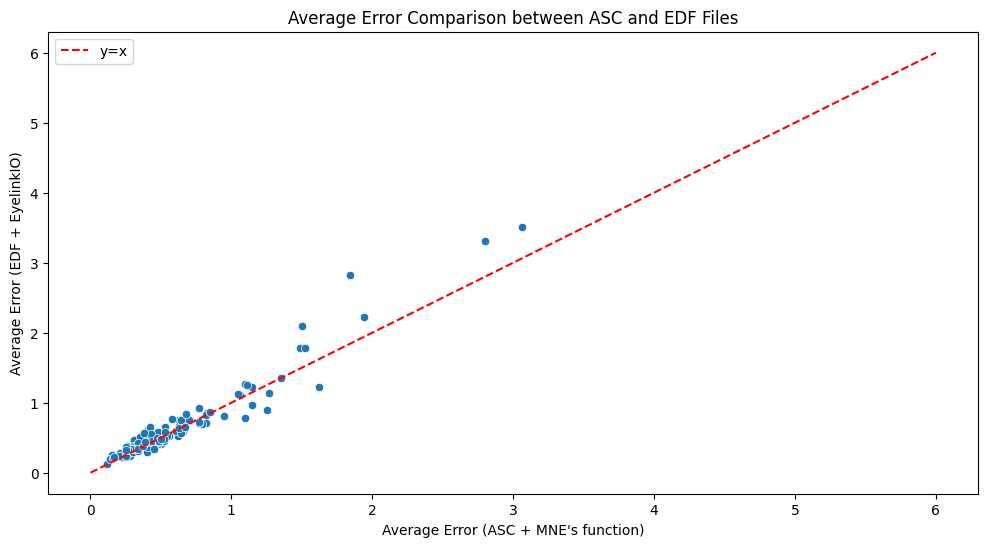

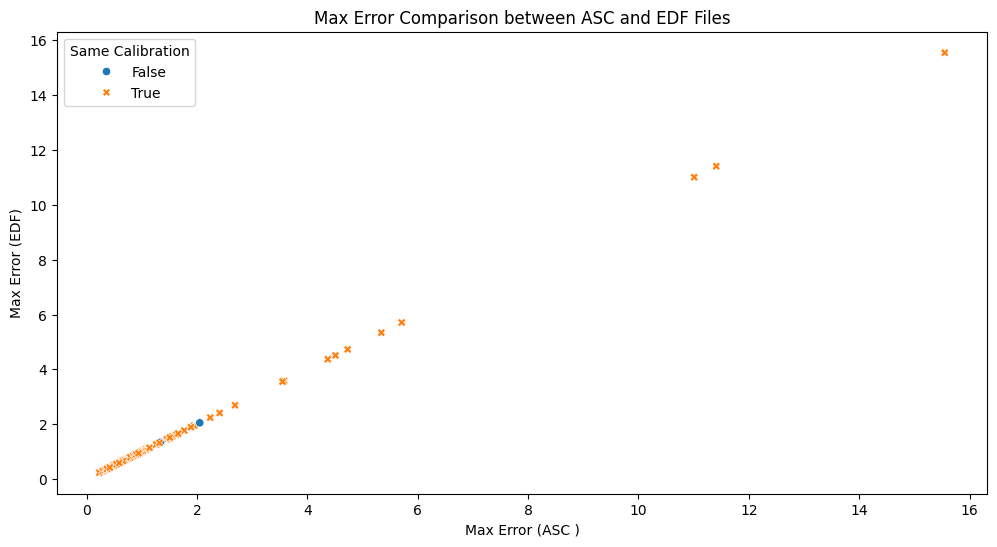

In [274]:
if run_test:
    # Merge with the calibration_df_asc and then compare the two dataframes if they are the same 
    calibration_df_merged = pd.merge(calibration_df_asc, calibration_df_edf, on="subject", suffixes=("_asc", "_edf"))
    # Check if the two dataframes are the same
    calibration_df_merged["same_calibration"] = (
        (calibration_df_merged["calibration_quality_asc"] == calibration_df_merged["calibration_quality_edf"])
    )


    # Remove subject with average error higher than 6
    calibration_df_merged = calibration_df_merged[calibration_df_merged["last_avg_error"] < 6]
    calibration_df_merged = calibration_df_merged[calibration_df_merged["avg_error"] < 6]
    # Plot average error and max error for both asc and edf files
    plt.figure(figsize=(12, 6))
    sns.scatterplot(data=calibration_df_merged, x="last_avg_error", y="avg_error")
    plt.title("Average Error Comparison between ASC and EDF Files")
    plt.xlabel("Average Error (ASC + MNE's function)")
    plt.ylabel("Average Error (EDF + EyelinkIO)")
    plt.legend(title="Same Calibration")
    # Plot diagnonal line for both plots
    x = np.linspace(0, 6, 100)
    plt.plot(x, x, color='red', linestyle='--', label='y=x')
    plt.legend()

    # Plot largest max error for both asc and edf files
    plt.figure(figsize=(12, 6))
    sns.scatterplot(data=calibration_df_merged, x="last_max_error", y="max_error", hue="same_calibration", style="same_calibration")
    plt.title("Max Error Comparison between ASC and EDF Files")
    plt.xlabel("Max Error (ASC )")
    plt.ylabel("Max Error (EDF)")
    plt.legend(title="Same Calibration")
    # Show legend
    plt.legend(title="Same Calibration")
    # Show the plot
    plt.show()



else: 
    print("Skipping ASC calibration processing test.")

Reading calibration data from C:\Users\gabot\OneDrive - McGill University\Desktop\github_repos\q1k_neurosubs\source\GO_files\asc_files\1078F1_GO.asc
Creating RawArray with float64 data, n_channels=3, n_times=65931
    Range : 0 ... 65930 =      0.000 ...   131.860 secs
Ready.
Calibration for subject 1078F1 using mne's read_eyelink_calibration:
Calibration |
  onset: -13.966 seconds
  model: HV5
  eye: left
  average error: 1.15 degrees
  max error: 1.34 degrees
  screen size: None meters
  screen distance: None meters
  screen resolution: None pixels

Calibration for subject 1078F1 using eyelink's read_edf().to_mne()
Calibration |
  onset: 0.0 seconds
  model: HV5
  eye: left
  average error: 0.962 degrees
  max error: 1.34 degrees
  screen size: None meters
  screen distance: None meters
  screen resolution: [1920 1080] pixels

Offsets for ASC file using mne's read_eyelink_calibration: [1.34 0.64 1.16 0.5  1.17]
Offsets for EDF file using read_edf().to_mne(): [1.34 0.64 1.16 0.5  1.17

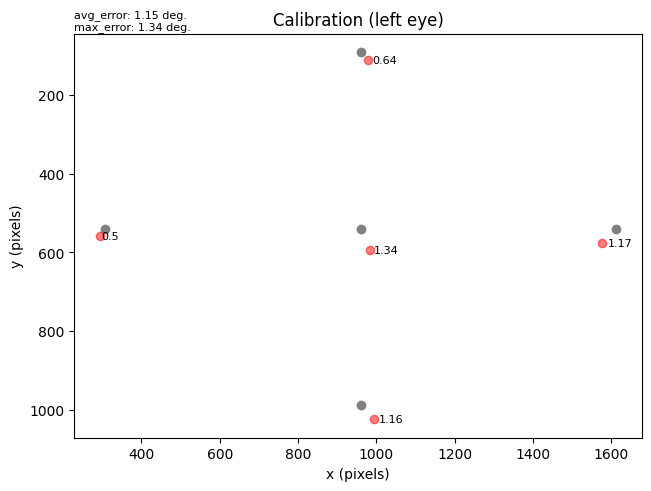

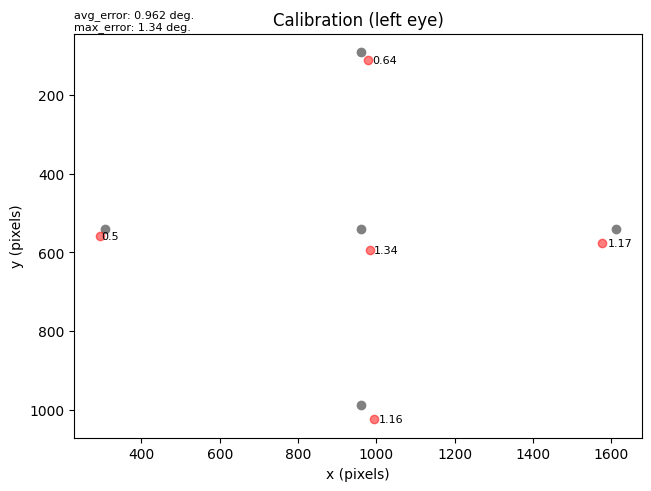

In [275]:
if run_test:
    # Check a data from two subjects

    # Get asc and edf files for subject 0043F1
    subject_id = "1078F1"
    asc_file = f"C:/Users/gabot/OneDrive - McGill University/Desktop/github_repos/q1k_neurosubs/source/GO_files/asc_files/{subject_id}_GO.asc"
    edf_file = f"C:/Users/gabot/OneDrive - McGill University/Desktop/github_repos/q1k_neurosubs/source/GO_files/edf_files/{subject_id}_GO.edf"
    # Read the asc file
    try:
        asc_cal = read_eyelink_calibration(asc_file)
    except Exception as e:
        print(f"Error reading asc file for subject {subject_id}: {e}")
        asc_cal = None
    # Read the edf file
    try:
        edf_data = read_edf(edf_file)
        edf_cal = edf_data.to_mne()[1]  # Get the calibration data
    except Exception as e:
        print(f"Error reading edf file for subject {subject_id}: {e}")
        edf_cal = None
    # Print the calibration data
    if asc_cal is not None:
        print(f"Calibration for subject {subject_id} using mne's read_eyelink_calibration:")
        print(asc_cal[-1])  # Print the last calibration
        
    if edf_cal is not None:
        print(f"Calibration for subject {subject_id} using eyelink's read_edf().to_mne()")
        print(edf_cal[-1])  # Print the last calibration
        
    # Extract the offsets and plot the calibration data
    if asc_cal is not None:
        offsets_asc = asc_cal[-1]["offsets"]
        print(f"Offsets for ASC file using mne's read_eyelink_calibration: {offsets_asc}")
    if edf_cal is not None:
        offsets_edf = edf_cal[-1]["offsets"]
        print(f"Offsets for EDF file using read_edf().to_mne(): {offsets_edf}")
    # Plot the calibration data for both asc and edf files
    if asc_cal is not None:
        fig_asc = asc_cal[-1].plot()
        fig_asc.suptitle(f"Calibration for subject {subject_id} - Using Asc file and mne's read_eyelink_calibration", fontsize=16)
        plt.show()
    if edf_cal is not None:
        fig_edf = edf_cal[-1].plot()
        fig_edf.suptitle(f"Calibration for subject {subject_id} - Using EDF file and read_edf().to_mne()", fontsize=16)
        # Add subtitle as text 
        plt.show()
    